In [1]:
import cmlreaders as cml
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import warnings; warnings.simplefilter('ignore')
pd.options.display.max_columns=None
pd.options.display.max_rows=100
from IPython.display import display, Markdown, HTML
import pandas_to_pybeh as pb
from tqdm import tqdm_notebook as lol
import time
import scipy
import rep_pybeh as rpb
from plotting import *
error_bars ={'elinewidth':3, 'capsize':5, 'capthick':3}
data_set = 'scalp'

## Hospital Data Load

In [2]:
if data_set == 'hospital':
    evs = []
    data = cml.get_data_index(kind = 'r1'); data = data[data['experiment'] == 'RepFR1']
    for subject, df in data.groupby('subject'):
        for session in pd.unique(df['session']):
            r = cml.CMLReader(subject=subject, experiment='RepFR1', session=session)
            temp = r.load('task_events')
            evs.append(temp)
    evs = pd.concat(evs)
    evs = evs[evs.list != 0]
    evs = evs[evs.repeats != -999]


    subs = evs.subject.unique()
    print(subs)

## Scalp Data Load

In [3]:
if data_set == 'scalp':
    evs = []
    data = cml.get_data_index(kind = 'ltp'); data = data[data['experiment'] == 'ltpRepFR']
    for subject, df in data.groupby('subject'):
        for session in pd.unique(df['session']):
            r = cml.CMLReader(subject=subject, experiment='ltpRepFR', session=session)
            temp = r.load('all_events')
            evs.append(temp)
    evs = pd.concat(evs)
    evs = evs[evs.list != 0]
    evs = evs[evs.repeats != -999]
    subs = evs.subject.unique()


    print(evs.subject.unique())

['LTP441' 'LTP442' 'LTP443' 'LTP444' 'LTP445' 'LTP446' 'LTP447']


In [4]:
evs['serialpos'] = evs.serialpos +1
evs = evs[evs.list != 0]
evs = evs[evs.list != 26]
word_evs = evs[evs.type=='WORD']
word_evs = word_evs.loc[word_evs.repeats != -999]
rec_evs = evs[evs.type=='REC_WORD']
rec_evs.reset_index(inplace=True)

In [5]:
rec_evs['rep_tran'] = rec_evs.groupby(['subject', 'session', 'list']).repeats.diff()
evs = word_evs.append(rec_evs)
evs = evs[evs['subject'] != 'R1204T']


In [6]:
crp = []
for sub, ahhh in evs.groupby(['subject']):
    sub_crp = []
    for sess, beh in ahhh.groupby('session'):
        sess_crp = pd.DataFrame(columns = ['rep_lag', 'prob'] )
        act_tran = np.zeros(5)
        pos_tran = np.zeros(5)
        for l, df in beh.groupby('list'):
            df.drop_duplicates('item_name')
            rec_evs = df[df['type'] == 'REC_WORD']
            tran = rec_evs.rep_tran.to_numpy()
            repeats = rec_evs.repeats.to_numpy()
            num_words = [3, 3, 6]

            for i, rep in enumerate(repeats):
                num_words[rep-1] -= 1
                try: 
                    act_tran[repeats[i+1] - rep + 2] += num_words[repeats[i+1]-1]
                    for j, val in enumerate(num_words):
                        pos_tran[(j+1) - rep + 2] += val
                except Exception as e: continue
                
        sess_crp['prob'] = act_tran/pos_tran
        sess_crp['rep_lag'] = pd.Series([-2, -1, 0,1,2])
        sess_crp['subject'] = pd.Series(sub, index = sess_crp.index)
        sess_crp['session'] = pd.Series(sess, index = sess_crp.index)
        sub_crp.append(sess_crp)
    crp.append(pd.concat(sub_crp))

crp = pd.concat(crp).reset_index()

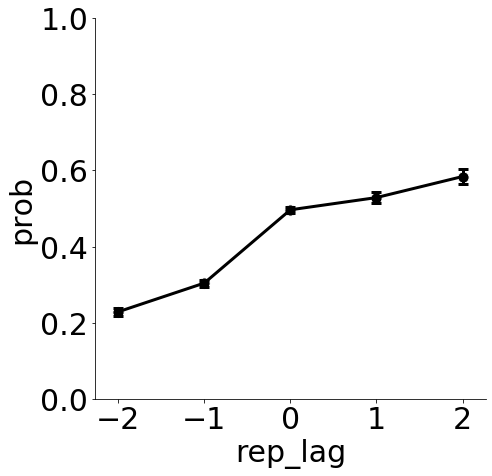

In [7]:
set_axes(fontsize=30, xticks = [-2, -1, 0, 1, 2])
plt.ylim(bottom=0)
sns.lineplot(data=crp, x = 'rep_lag', y = 'prob', err_style='bars', linewidth = 3, color = 'black', err_kws = error_bars)
sns.scatterplot(data= crp.groupby('rep_lag').mean().reset_index(), x = 'rep_lag', y = 'prob', s = 125, color= 'black')

In [8]:
crp = []
for sub, ahhh in evs.groupby(['subject']):
    sub_crp = []
    for sess, beh in ahhh.groupby('session'):
        sess_crp = pd.DataFrame(columns = ['rep_lag', 'prob'] )
        act_tran = np.zeros(5)
        pos_tran = np.zeros(5)
        for l, df in beh.groupby('list'):
            df.drop_duplicates('item_name')
            rec_evs = df[df['type'] == 'REC_WORD']
            tran = rec_evs.rep_tran.to_numpy()
            repeats = rec_evs.repeats.to_numpy()
            num_words = [3, 3, 6]

            for i, rep in enumerate(repeats):
                num_words[rep-1] -= 1
                if rep == 1:
                    try: 
                        act_tran[repeats[i+1] - rep + 2] += num_words[repeats[i+1]-1]
                        for j, val in enumerate(num_words):
                            pos_tran[(j+1) - rep + 2] += val
                    except Exception as e: continue
        sess_crp['prob'] = act_tran/pos_tran
        sess_crp['rep_lag'] = pd.Series([-2, -1, 0,1,2])
        sess_crp['subject'] = pd.Series(sub, index = sess_crp.index)
        sess_crp['session'] = pd.Series(sess, index = sess_crp.index)
        sub_crp.append(sess_crp)
    crp.append(pd.concat(sub_crp))

crp = pd.concat(crp).reset_index()

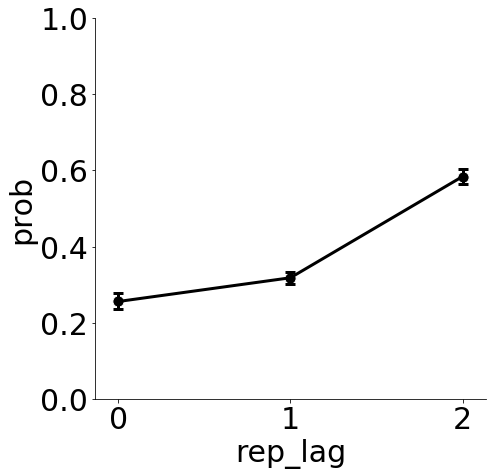

In [9]:
set_axes(fontsize=30, xticks = [-2, -1, 0, 1, 2])
_ = plt.ylim(bottom=0)
sns.lineplot(data=crp, x = 'rep_lag', y = 'prob', err_style='bars', linewidth = 3, color = 'black', err_kws = error_bars)
sns.scatterplot(data= crp.groupby('rep_lag').mean().reset_index(), x = 'rep_lag', y = 'prob', s = 125, color= 'black')

In [10]:
crp = []
for sub, ahhh in evs.groupby(['subject']):
    sub_crp = []
    for sess, beh in ahhh.groupby('session'):
        sess_crp = pd.DataFrame(columns = ['rep_lag', 'prob'] )
        act_tran = np.zeros(5)
        pos_tran = np.zeros(5)
        for l, df in beh.groupby('list'):
            df.drop_duplicates('item_name')
            rec_evs = df[df['type'] == 'REC_WORD']
            tran = rec_evs.rep_tran.to_numpy()
            repeats = rec_evs.repeats.to_numpy()
            num_words = [3, 3, 6]

            for i, rep in enumerate(repeats):
                num_words[rep-1] -= 1
                if rep == 2:
                    try: 
                        act_tran[repeats[i+1] - rep + 2] += num_words[repeats[i+1]-1]
                        for j, val in enumerate(num_words):
                            pos_tran[(j+1) - rep + 2] += val
                    except Exception as e: continue
        sess_crp['prob'] = act_tran/pos_tran
        sess_crp['rep_lag'] = pd.Series([-2, -1, 0,1,2])
        sess_crp['subject'] = pd.Series(sub, index = sess_crp.index)
        sess_crp['session'] = pd.Series(sess, index = sess_crp.index)
        sub_crp.append(sess_crp)
    crp.append(pd.concat(sub_crp))

crp = pd.concat(crp).reset_index()

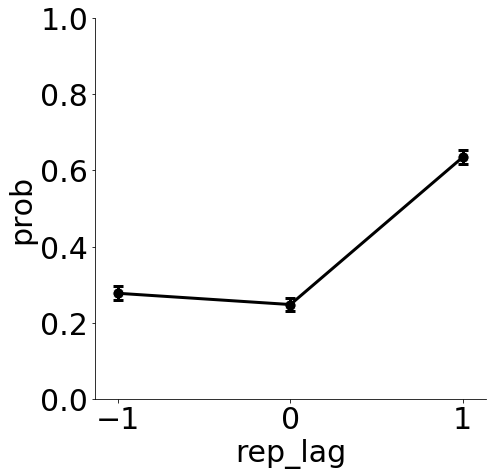

In [11]:
set_axes(fontsize=30, xticks = [-2, -1, 0, 1, 2], ylim = [0, 1])
sns.lineplot(data=crp, x = 'rep_lag', y = 'prob', err_style='bars', linewidth = 3, color = 'black', err_kws = error_bars)
sns.scatterplot(data= crp.groupby('rep_lag').mean().reset_index(), x = 'rep_lag', y = 'prob', s = 125, color= 'black')

In [12]:
crp = []
for sub, ahhh in evs.groupby(['subject']):
    sub_crp = []
    for sess, beh in ahhh.groupby('session'):
        sess_crp = pd.DataFrame(columns = ['rep_lag', 'prob'] )
        act_tran = np.zeros(5)
        pos_tran = np.zeros(5)
        for l, df in beh.groupby('list'):
            df.drop_duplicates('item_name')
            rec_evs = df[df['type'] == 'REC_WORD']
            tran = rec_evs.rep_tran.to_numpy()
            repeats = rec_evs.repeats.to_numpy()
            num_words = [3, 3, 6]

            for i, rep in enumerate(repeats):
                num_words[rep-1] -= 1
                if rep == 3:
                    try: 
                        act_tran[repeats[i+1] - rep + 2] += num_words[repeats[i+1]-1]
                        for j, val in enumerate(num_words):
                            pos_tran[(j+1) - rep + 2] += val
                    except Exception as e: continue
        sess_crp['prob'] = act_tran/pos_tran
        sess_crp['rep_lag'] = pd.Series([-2, -1, 0,1,2])
        sess_crp['subject'] = pd.Series(sub, index = sess_crp.index)
        sess_crp['session'] = pd.Series(sess, index = sess_crp.index)
        sub_crp.append(sess_crp)
    crp.append(pd.concat(sub_crp))

crp = pd.concat(crp).reset_index()

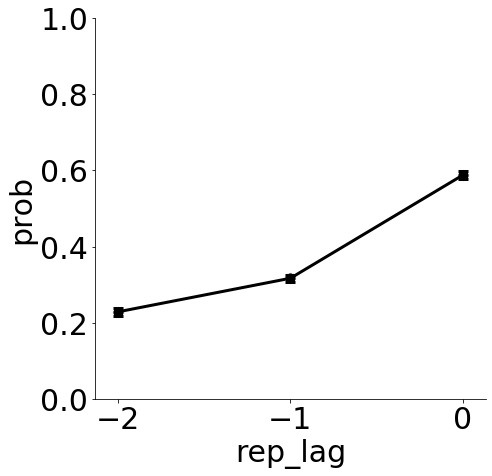

In [13]:
set_axes(fontsize=30, xticks = [-2, -1, 0, 1, 2], ylim = [0, 1])
sns.lineplot(data=crp, x = 'rep_lag', y = 'prob', err_style='bars', linewidth = 3, color = 'black', err_kws = error_bars)
sns.scatterplot(data= crp.groupby('rep_lag').mean().reset_index(), x = 'rep_lag', y = 'prob', s = 125, color= 'black')

In [230]:
print(pos_tran)

[295. 261. 371.   0.   0.]


In [138]:
print(act_tran)

[ 0.  0. 14. 25. 34.]
